# Unsupervised Language Learning, Lab1

## Adriaan de Vries (10795227), Verna Dankers (10761225)

Hier komt een verhaaltje over de eerste opdracht.

Before being able to run this code, please import the following libraries and set the following paths to the datasets. Afterwards, the code should run without issues.

In [91]:
# Requirements
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict, Counter
from scipy.stats import spearmanr, pearsonr
from tabulate import tabulate
from gensim.models import KeyedVectors
from gensim.corpora.dictionary import Dictionary
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt

# Paths to datasets
bow2_filename = "data/bow2.words"
bow5_filename = "data/bow5.words"
deps_filename = "data/deps.words"
simlex_filename = "data/SimLex-999.txt"
men_filename = "data/men/MEN_dataset_natural_form_full"
analogy_filename = "data/questions-words.txt"
common_words_filename = "data/common_words.words"
create_tables = False

In [2]:
# glove2word2vec(bow2_filename, bow2_filename.split(".")[0] + ".txt")
# glove2word2vec(bow5_filename, bow5_filename.split(".")[0] + ".txt")
# glove2word2vec(deps_filename, deps_filename.split(".")[0] + ".txt")
bow2 = KeyedVectors.load_word2vec_format(bow2_filename.split(".")[0] + ".txt", binary=False)
bow2.init_sims(replace=True)
bow5 = KeyedVectors.load_word2vec_format(bow5_filename.split(".")[0] + ".txt", binary=False)
bow5.init_sims(replace=True)
deps = KeyedVectors.load_word2vec_format(deps_filename.split(".")[0] + ".txt", binary=False)
deps.init_sims(replace=True)

### 1. Collect and examine the word embeddings

In [3]:
print(deps.most_similar(positive=['reddish'])[0])
print(bow5.most_similar(positive=['cop'])[0])
print(bow2.most_similar(positive=['tissue'])[0])

print(deps.most_similar(positive=['sudoku'])[0])
print(bow5.most_similar(positive=['sudoku'])[0])
print(bow2.most_similar(positive=['sudoku'])[0])

('yellowish', 0.90565025806427)
('gangster', 0.6121816039085388)
('tissues', 0.8125388026237488)
('euchre', 0.8477352857589722)
('puzzles', 0.6697622537612915)
('tic-tac-toe', 0.7244439125061035)


### 2. Collect the SimLex and MEN data to evaluate the quality of the word embeddings

#### Quantitative Analysis

In [14]:
# Read in simlex and men data
simlex = dict()
men = dict()

with open(simlex_filename, 'r') as f:
    headers = f.readline().split()[2:]
    for line in f:
        line = line.split()
        simlex[(line[0], line[1])] = dict(
            [(header, float(score)) for header, score in zip(headers[1:], line[3:])]
        )
        simlex[(line[0], line[1])][headers[0]] = line[2] 

with open(men_filename, 'r') as f:
    for line in f:
        line = line.split()
        men[(line[0], line[1])] = float(line[2])

In [124]:
def score_men(men, embeddings):
    scores = [[], []]
    bad = []
    best = []
    for pair in men:
        try:
            scores[0].append(embeddings.similarity(pair[0], pair[1]))
            scores[1].append(men[pair])
            if (scores[0][-1] > 0.75 and scores[1][-1] < 12.5) or (scores[0][-1] < 0.25 and scores[1][-1] > 37.5):
                bad.append("({}, {}), {:.2f}, {:.2f}".format(pair[0], pair[1], scores[0][-1], scores[1][-1]))
            if (scores[0][-1] > 0.75 and scores[1][-1] > 37.5):
                best.append("({}, {}), {:.2f}, {:.2f}".format(pair[0], pair[1], scores[0][-1], scores[1][-1]))
        except KeyError:
            continue
    return (scores[0], scores[1], bad, best)

def score_simlex(simlex, name, embeddings):
    scores = [[], []]
    bad = []
    best = []
    for pair in simlex:
        try:
            scores[0].append(embeddings.similarity(pair[0], pair[1]))
            scores[1].append(simlex[pair][name])
            if (scores[0][-1] > 0.75 and scores[1][-1] < 2.5) or (scores[0][-1] < 0.25 and scores[1][-1] > 7.5):
                bad.append("({}, {}), {:.2f}, {:.2f}".format(pair[0], pair[1], scores[0][-1], scores[1][-1]))
            if (scores[0][-1] > 0.75 and scores[1][-1] > 7.5):
                best.append("({}, {}), {:.2f}, {:.2f}".format(pair[0], pair[1], scores[0][-1], scores[1][-1]))
        except KeyError:
            continue
    return (scores[0], scores[1], bad, best)

def score_simlex_pos(simlex, name, embeddings):
    scores = [defaultdict(list), defaultdict(list)]
    for pair in simlex:
        try:
            scores[0][simlex[pair]["POS"]].append(embeddings.similarity(pair[0], pair[1]))
            scores[1][simlex[pair]["POS"]].append(simlex[pair][name])
        except KeyError:
            continue
    return (scores[0], scores[1])

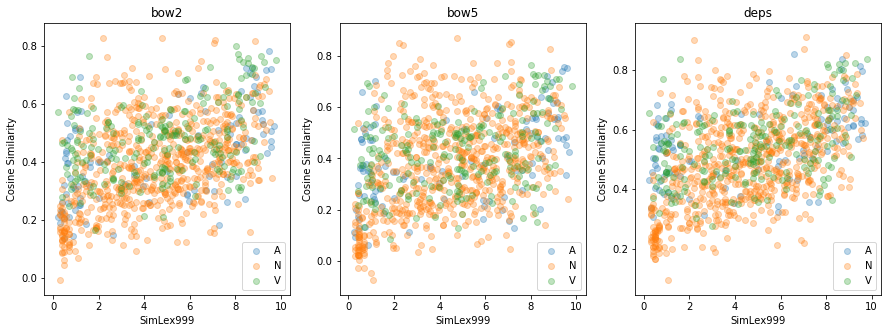

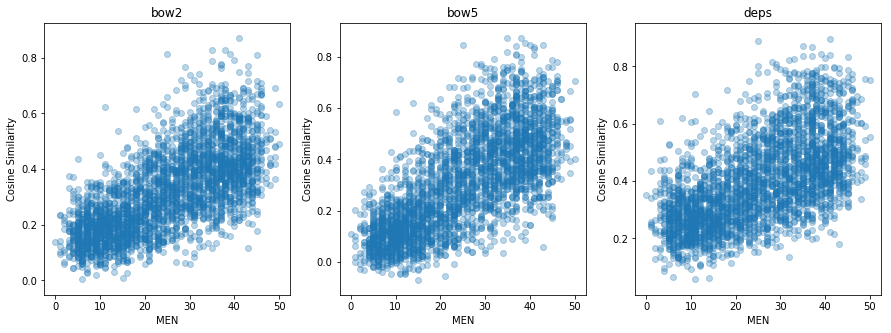

In [125]:
figure = plt.figure()
figure.set_size_inches(15, 5)
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot = score_simlex_pos(simlex, "SimLex999", data)
    
    colours = ["blue", "green", "red"]
    plt.subplot(1, 3, i+1)
    for j, pos in enumerate(xplot.keys()):
        plt.scatter(xplot[pos], yplot[pos], alpha=0.3, label=pos)
    plt.legend()
    plt.xlabel("SimLex999")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()

figure = plt.figure()
figure.set_size_inches(15, 5)
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot, men_bad_samples, men_best_samples = score_men(men, data)
    plt.subplot(1, 3, i+1)
    plt.scatter(xplot, yplot, alpha=0.3)
    plt.xlabel("MEN")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()

### 3. Pearson's $\rho$ and Spearman's $\rho$

In [126]:
results = []
results_pos = []
all_men_bad_samples = dict()
all_simlex_bad_samples = dict()
all_men_best_samples = dict()
all_simlex_best_samples = dict()
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    # MEN
    embed_results, gold, men_bad_samples, men_best_samples = score_men(men, data)
    all_men_bad_samples[name] = men_bad_samples
    all_men_best_samples[name] = men_best_samples
    spearman = spearmanr(embed_results, gold)
    pearson = pearsonr(embed_results, gold)
    results.append((name, "MEN", spearman[0], spearman[1], pearson[0], pearson[1]))

    # SIMLEX
    embed_results, gold, simlex_bad_samples, simlex_best_samples = score_simlex(simlex, "SimLex999", data)
    all_simlex_bad_samples[name] = simlex_bad_samples
    all_simlex_best_samples[name] = simlex_best_samples
    spearman = spearmanr(embed_results, gold)
    pearson = pearsonr(embed_results, gold)
    results.append((name, "SimLex", spearman[0], spearman[1], pearson[0], pearson[1]))
    
    # SIMLEX per POS tag
    embed_results, gold = score_simlex_pos(simlex, "SimLex999", data)
    for POS in embed_results:
        spearman = spearmanr(embed_results[POS], gold[POS])
        pearson = pearsonr(embed_results[POS], gold[POS])
        results_pos.append((name, "SimLex + {}".format(POS), spearman[0], spearman[1], pearson[0], pearson[1]))

In [127]:
print("Correlation Coefficients for all pairs in the data")
headers = ['Embeddings', 'Gold standard', 'Spearman\'s r',
           'Spearman p-value', 'Pearson\'s r', 'Pearson p-value' ]
print(tabulate(results, headers=headers, tablefmt="fancy_grid"))

print("Correlation Coefficients per POS tag")
headers = ['Embeddings', 'Gold standard', 'Spearman\'s r',
           'Spearman p-value', 'Pearson\'s r', 'Pearson p-value' ]
print(tabulate(results_pos, headers=headers, tablefmt="fancy_grid"))

Correlation Coefficients for all pairs in the data
╒══════════════╤═════════════════╤════════════════╤════════════════════╤═══════════════╤═══════════════════╕
│ Embeddings   │ Gold standard   │   Spearman's r │   Spearman p-value │   Pearson's r │   Pearson p-value │
╞══════════════╪═════════════════╪════════════════╪════════════════════╪═══════════════╪═══════════════════╡
│ bow2         │ MEN             │       0.699905 │       0            │      0.677698 │      0            │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow2         │ SimLex          │       0.414146 │       1.22681e-42  │      0.428459 │      7.993e-46    │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow5         │ MEN             │       0.723169 │       0            │      0.708236 │      0            │
├──────────────┼─────────────────┼────────────────┼────────────────────┼─────

#### Qualitative Analysis

To perform a qualitative analysis, we first take a look at pairs for which either the ground truth gives a high score and the embeddings give a low score, or the ground truth gives a low score and the embeddings give a high score. High has been defined as > 7.5 for SimLex, > 37.5 for MEN and > 0.75 for the Cosine similarity. Low has been defined as < 2.5 for SimLex, < 12.5 for MEN and < 0.25 for Cosine similarity. Second, we also check the best samples: samples for which the embeddings and MEN or SimLex mostly agree (> 7.5, > 37.5, > 0.75). Below the tables are listed, first for the bad samples and second for the best samples.

We list our findings about these samples:
1. Upon comparing the SimLex and MEN results for bad samples, we noticed that the set of wrongly scored samples compared to the SimLex scores contains many antonyms (e.g. _encourage / discourage_, _reject / accept_, _summer / winter_), whereas the bad samples retrieved for MEN do not contain antonyms. The antonym pairs are assigned a relatively high similarity score according to the embeddings, but a low score according to SimLex. This can be explained by taking into account how the SimLex score was determined, by asking participants to judge how similar two words are. Although humans might judge that antonyms are related, they may not be judged similar, because they are actually opposites. In text corpora however, it can be difficult to capture this subtle difference. Antonyms may seem similar in corpora because their contexts are often very similar. (_'After the speech I felt encouraged / discouraged'_, _'The company accepted / rejected the proposal.'_, _'I love the summer / winter weather.'_)
2. For MEN bad samples, we only see scores that are underestimated for all three types of embeddings. Although it is not consistent for all pairs, we do notice that quite some pairs contain different part of speech tags (e.g. (bed, relaxed), (automobile, parking), (morning, sunny)). In contrast, the best samples only contain pairs of words that have roughly the same part of speech tag. Possibly, words within the same domain but of a different type are farther apart than words of the same type. For SimLex we cannot distinguish this because all word pairs in the data set have the same tag.
3. For SimLex bad samples, Bow2 and Bow5 both show underestimations and overestimations, but Deps only gives overestimations. The overestimations are mainly antonyms (discussed in 1.). The underestimations are mainly words that behave similar in a sentence, but not necessarily belong to one topic or domain. That the Deps embeddings do not show such badly scored samples, may be because they are better at capturing functional similarity (Levy and Goldberg, 2014).

MEN - bad samples

<table>
<thead>
<tr><th>Bow2                              </th><th>Bow5                               </th><th>Deps                          </th></tr>
</thead>
<tbody>
<tr><td>(day, sunset), 0.24, 43.00        </td><td>(day, sunset), 0.23, 43.00         </td><td>(bed, relaxed), 0.24, 39.00   </td></tr>
<tr><td>(guitar, rock), 0.24, 39.00       </td><td>(handwriting, written), 0.22, 44.00</td><td>(leaf, nature), 0.18, 43.00   </td></tr>
<tr><td>(day, sunshine), 0.23, 42.00      </td><td>(automobile, parking), 0.24, 41.00 </td><td>(petals, rose), 0.21, 42.00   </td></tr>
<tr><td>(automobile, parking), 0.24, 41.00</td><td>(ivy, plant), 0.17, 45.00          </td><td>(pregnant, women), 0.22, 41.00</td></tr>
<tr><td>(ivy, plant), 0.18, 45.00         </td><td>(van, vehicle), 0.14, 40.00        </td><td>(parrot, wing), 0.20, 38.00   </td></tr>
<tr><td>(van, vehicle), 0.23, 40.00       </td><td>(interior, room), 0.21, 39.00      </td><td>                              </td></tr>
<tr><td>(shore, water), 0.24, 45.00       </td><td>(shore, water), 0.22, 45.00        </td><td>                              </td></tr>
<tr><td>(morning, sunny), 0.22, 40.00     </td><td>(morning, sunny), 0.23, 40.00      </td><td>                              </td></tr>
<tr><td>(bed, relaxed), 0.21, 39.00       </td><td>(bed, relaxed), 0.12, 39.00        </td><td>                              </td></tr>
<tr><td>(clothes, jean), 0.16, 39.00      </td><td>(clothes, jean), 0.09, 39.00       </td><td>                              </td></tr>
</tbody>
</table>

SimLex-999 - bad samples
<table>
<thead>
<tr><th>Bow2                               </th><th>Bow5                          </th><th>Deps                               </th></tr>
</thead>
<tbody>
<tr><td>(encourage, discourage), 0.77, 1.58</td><td>(dog, cat), 0.77, 1.75        </td><td>(dog, cat), 0.78, 1.75             </td></tr>
<tr><td>(buddy, companion), 0.16, 8.65     </td><td>(keep, possess), 0.15, 8.27   </td><td>(accept, reject), 0.77, 0.83       </td></tr>
<tr><td>(south, north), 0.83, 2.20         </td><td>(certain, sure), 0.20, 8.42   </td><td>(encourage, discourage), 0.84, 1.58</td></tr>
<tr><td>(winter, summer), 0.76, 2.38       </td><td>(satisfy, please), 0.17, 7.67 </td><td>(south, north), 0.90, 2.20         </td></tr>
<tr><td>                                   </td><td>(come, attend), 0.21, 8.10    </td><td>(cat, rabbit), 0.78, 2.37          </td></tr>
<tr><td>                                   </td><td>(begin, originate), 0.19, 8.20</td><td>(winter, summer), 0.84, 2.38       </td></tr>
<tr><td>                                   </td><td>(buddy, companion), 0.14, 8.65</td><td>(lawyer, banker), 0.77, 1.88       </td></tr>
<tr><td>                                   </td><td>(racket, noise), 0.18, 8.10   </td><td>                                   </td></tr>
<tr><td>                                   </td><td>(south, north), 0.85, 2.20    </td><td>                                   </td></tr>
<tr><td>                                   </td><td>(winter, summer), 0.84, 2.38  </td><td>                                   </td></tr>
</tbody>
</table>

MEN - best samples
<table>
<thead>
<tr><th>Bow2                               </th><th>Bow5                               </th><th>Deps                             </th></tr>
</thead>
<tbody>
<tr><td>(gold, silver), 0.79, 40.00        </td><td>(autumn, spring), 0.76, 44.00      </td><td>(guitar, piano), 0.78, 43.00     </td></tr>
<tr><td>(beef, meat), 0.77, 43.00          </td><td>(gold, silver), 0.84, 40.00        </td><td>(beetles, insects), 0.75, 40.00  </td></tr>
<tr><td>(bicycle, bike), 0.81, 45.00       </td><td>(beef, meat), 0.84, 43.00          </td><td>(gold, silver), 0.83, 40.00      </td></tr>
<tr><td>(amphibians, reptiles), 0.87, 41.00</td><td>(beef, chicken), 0.80, 38.00       </td><td>(cafe, restaurant), 0.79, 42.00  </td></tr>
<tr><td>(cattle, sheep), 0.83, 38.00       </td><td>(bicycle, bike), 0.79, 45.00       </td><td>(aircraft, airplane), 0.76, 46.00</td></tr>
<tr><td>(carrots, potatoes), 0.81, 39.00   </td><td>(amphibians, reptiles), 0.84, 41.00</td><td>(harbor, harbour), 0.80, 40.00   </td></tr>
<tr><td>                                   </td><td>(cattle, sheep), 0.87, 38.00       </td><td>(chapel, church), 0.76, 45.00    </td></tr>
<tr><td>                                   </td><td>(daughter, son), 0.83, 41.00       </td><td>(bus, tram), 0.78, 38.00         </td></tr>
<tr><td>                                   </td><td>(pink, purple), 0.75, 38.00        </td><td>(town, village), 0.79, 43.00     </td></tr>
<tr><td>                                   </td><td>(coffee, tea), 0.76, 45.00         </td><td>(bicycle, bike), 0.83, 45.00     </td></tr>
</tbody>
</table>

SimLex-999 - best samples
<table>
<thead>
<tr><th>Bow2                              </th><th>Bow5                           </th><th>Deps                               </th></tr>
</thead>
<tbody>
<tr><td>(appoint, elect), 0.76, 8.17      </td><td>(stupid, dumb), 0.75, 9.58     </td><td>(inform, notify), 0.82, 9.25       </td></tr>
<tr><td>(investigate, examine), 0.77, 8.10</td><td>(movie, film), 0.82, 8.87      </td><td>(orthodontist, dentist), 0.78, 8.27</td></tr>
<tr><td>(vanish, disappear), 0.75, 9.80   </td><td>(analyze, evaluate), 0.76, 8.03</td><td>(clarify, explain), 0.79, 8.33     </td></tr>
<tr><td>(protect, defend), 0.76, 9.13     </td><td>(large, huge), 0.76, 9.47      </td><td>(attorney, lawyer), 0.79, 9.35     </td></tr>
<tr><td>(acquire, obtain), 0.76, 8.57     </td><td>                               </td><td>(investigate, examine), 0.81, 8.10 </td></tr>
<tr><td>(movie, film), 0.82, 8.87         </td><td>                               </td><td>(stupid, dumb), 0.80, 9.58         </td></tr>
<tr><td>(analyze, evaluate), 0.80, 8.03   </td><td>                               </td><td>(achieve, accomplish), 0.82, 8.57  </td></tr>
<tr><td>(large, huge), 0.78, 9.47         </td><td>                               </td><td>(crucial, important), 0.76, 8.82   </td></tr>
<tr><td>                                  </td><td>                               </td><td>(vanish, disappear), 0.84, 9.80    </td></tr>
<tr><td>                                  </td><td>                               </td><td>(protect, defend), 0.78, 9.13      </td></tr>
</tbody>
</table>

In [131]:
if create_tables:
    print("MEN - bad samples")
    table = list(itertools.zip_longest(all_men_bad_samples["bow2"],
                 all_men_bad_samples["bow5"], all_men_bad_samples["deps"]))[:10]
    print(tabulate(table,
                   headers=['Bow2', 'Bow5', 'Deps'], tablefmt='fancy'))

    print("SimLex-999 - bad samples")
    table = list(itertools.zip_longest(all_simlex_bad_samples["bow2"],
                 all_simlex_bad_samples["bow5"], all_simlex_bad_samples["deps"]))[:10]
    print(tabulate(table,
                   headers=['Bow2', 'Bow5', 'Deps'], tablefmt='fancy'))

    print("MEN - best samples")
    table = list(itertools.zip_longest(all_men_best_samples["bow2"],
                 all_men_best_samples["bow5"], all_men_best_samples["deps"]))[:10]
    print(tabulate(table,
                   headers=['Bow2', 'Bow5', 'Deps'], tablefmt='fancy'))

    print("SimLex-999 - best samples")
    table = list(itertools.zip_longest(all_simlex_best_samples["bow2"],
                 all_simlex_best_samples["bow5"], all_simlex_best_samples["deps"]))[:10]
    print(tabulate(table,
                   headers=['Bow2', 'Bow5', 'Deps'], tablefmt='fancy'))

### 4. Analogy Task

#### Quantitative Analysis

<table>
<thead>
<tr><th style="text-align: right;">     </th><th>Topic                      </th><th style="text-align: right;">  Acc. Bow2</th><th style="text-align: right;">  MRR Bow2</th><th style="text-align: right;">  Acc. Bow5</th><th style="text-align: right;">  MRR Bow5</th><th style="text-align: right;">  Acc. Deps</th><th style="text-align: right;">  MRR Deps</th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">  992</td><td>gram1-adjective-to-adverb  </td><td style="text-align: right;">  0.0413306</td><td style="text-align: right;"> 0.161058 </td><td style="text-align: right;">  0.0715726</td><td style="text-align: right;">  0.204696</td><td style="text-align: right;"> 0.0110887 </td><td style="text-align: right;"> 0.0495402</td></tr>
<tr><td style="text-align: right;">  506</td><td>capital-common-countries   </td><td style="text-align: right;">  0.701581 </td><td style="text-align: right;"> 0.809525 </td><td style="text-align: right;">  0.926877 </td><td style="text-align: right;">  0.956023</td><td style="text-align: right;"> 0.00592885</td><td style="text-align: right;"> 0.284677 </td></tr>
<tr><td style="text-align: right;">  870</td><td>gram9-plural-verbs         </td><td style="text-align: right;">  0.768966 </td><td style="text-align: right;"> 0.844115 </td><td style="text-align: right;">  0.703448 </td><td style="text-align: right;">  0.80378 </td><td style="text-align: right;"> 0.904598  </td><td style="text-align: right;"> 0.942274 </td></tr>
<tr><td style="text-align: right;"> 1599</td><td>gram6-nationality-adjective</td><td style="text-align: right;">  0.57536  </td><td style="text-align: right;"> 0.71328  </td><td style="text-align: right;">  0.782989 </td><td style="text-align: right;">  0.84296 </td><td style="text-align: right;"> 0.00562852</td><td style="text-align: right;"> 0.139885 </td></tr>
<tr><td style="text-align: right;">  866</td><td>currency                   </td><td style="text-align: right;">  0.0123839</td><td style="text-align: right;"> 0.0906957</td><td style="text-align: right;">  0.0386997</td><td style="text-align: right;">  0.116888</td><td style="text-align: right;"> 0.0100671 </td><td style="text-align: right;"> 0.0623488</td></tr>
<tr><td style="text-align: right;"> 2467</td><td>city-in-state              </td><td style="text-align: right;">  0.014998 </td><td style="text-align: right;"> 0.281772 </td><td style="text-align: right;">  0.369274 </td><td style="text-align: right;">  0.535011</td><td style="text-align: right;"> 0         </td><td style="text-align: right;"> 0.139206 </td></tr>
<tr><td style="text-align: right;"> 1560</td><td>gram7-past-tense           </td><td style="text-align: right;">  0.488462 </td><td style="text-align: right;"> 0.620581 </td><td style="text-align: right;">  0.509615 </td><td style="text-align: right;">  0.643276</td><td style="text-align: right;"> 0.630128  </td><td style="text-align: right;"> 0.714728 </td></tr>
<tr><td style="text-align: right;"> 1332</td><td>gram8-plural               </td><td style="text-align: right;">  0.662913 </td><td style="text-align: right;"> 0.753993 </td><td style="text-align: right;">  0.615616 </td><td style="text-align: right;">  0.721585</td><td style="text-align: right;"> 0.633634  </td><td style="text-align: right;"> 0.724538 </td></tr>
<tr><td style="text-align: right;">  506</td><td>family                     </td><td style="text-align: right;">  0.70751  </td><td style="text-align: right;"> 0.806665 </td><td style="text-align: right;">  0.756917 </td><td style="text-align: right;">  0.837948</td><td style="text-align: right;"> 0.786561  </td><td style="text-align: right;"> 0.838142 </td></tr>
<tr><td style="text-align: right;"> 4524</td><td>capital-world              </td><td style="text-align: right;">  0.44695  </td><td style="text-align: right;"> 0.615472 </td><td style="text-align: right;">  0.657162 </td><td style="text-align: right;">  0.771783</td><td style="text-align: right;"> 0.005084  </td><td style="text-align: right;"> 0.130739 </td></tr>
<tr><td style="text-align: right;"> 1332</td><td>gram3-comparative          </td><td style="text-align: right;">  0.867117 </td><td style="text-align: right;"> 0.923144 </td><td style="text-align: right;">  0.782282 </td><td style="text-align: right;">  0.86285 </td><td style="text-align: right;"> 0.707207  </td><td style="text-align: right;"> 0.80205  </td></tr>
<tr><td style="text-align: right;">  812</td><td>gram2-opposite             </td><td style="text-align: right;">  0.258621 </td><td style="text-align: right;"> 0.365464 </td><td style="text-align: right;">  0.253695 </td><td style="text-align: right;">  0.366234</td><td style="text-align: right;"> 0.355911  </td><td style="text-align: right;"> 0.449354 </td></tr>
<tr><td style="text-align: right;"> 1122</td><td>gram4-superlative          </td><td style="text-align: right;">  0.464962 </td><td style="text-align: right;"> 0.633822 </td><td style="text-align: right;">  0.369318 </td><td style="text-align: right;">  0.575971</td><td style="text-align: right;"> 0.392992  </td><td style="text-align: right;"> 0.542299 </td></tr>
<tr><td style="text-align: right;"> 1056</td><td>gram5-present-participle   </td><td style="text-align: right;">  0.539773 </td><td style="text-align: right;"> 0.69503  </td><td style="text-align: right;">  0.628788 </td><td style="text-align: right;">  0.755845</td><td style="text-align: right;"> 0.619318  </td><td style="text-align: right;"> 0.72413  </td></tr>
<tr><td style="text-align: right;">19544</td><td>All                        </td><td style="text-align: right;">  0.440388 </td><td style="text-align: right;"> 0.586389 </td><td style="text-align: right;">  0.551096 </td><td style="text-align: right;">  0.667913</td><td style="text-align: right;"> 0.279259  </td><td style="text-align: right;"> 0.389598 </td></tr>
</tbody>
</table>

#### Qualitative Analysis

In [9]:
analogies = defaultdict(list)
with open(analogy_filename, 'r') as f:
    for line in f:
        if line[0] == ":":
            topic = line.split()[-1]
        else:
            analogies[topic].append(tuple(line.split()))

In [13]:
def analogy_task(topics, analogies, embeddings):
    """Calculate the accuracy and MRR for embeddings on an analogy task.
    
    Args:
        analogies: dictionary with topics as keys and a list of word tuples as values
        embeddings: dictionary of word embeddings, words as keys and vectors as values
    Returns:
        float: accuracy
        float: MRR
    """
    accuracies = []
    mrrs = []
    all_mrr = 0
    all_correct = 0
    all_present = 0
    wrong_examples = defaultdict(list)
    for topic in tqdm(topics):
        topic_mrr = 0
        topic_correct = 0
        topic_present = 0
        for (a, a_star, b, b_star) in analogies[topic]:
            # If words with capital letters are not in the vectors, try to lowercase
            if a not in embeddings: a = a.lower()
            if a_star not in embeddings: a_star = a_star.lower()
            if b not in embeddings: b = b.lower()
            if b_star not in embeddings: b_star = b_star.lower()

            # If words from the analogy are not in the embeddings, do not let it count
            if any([word not in embeddings for word in [a, a_star, b, b_star]]):
                continue

            # Get the vector closest to the calculated analogy vector
            b_star_approx = embeddings[b] + (embeddings[a_star] - embeddings[a])
            b_star_approx = b_star_approx / np.linalg.norm(b_star_approx)
            words, similarities = zip(*list(embeddings.similar_by_vector(b_star_approx, topn=5000)))

            # Do not take b into account
            words = list(words)
            if b in words: words.remove(b)
            b_star_approx = words[0]

            # Calculate reciprocal rank for MRR
            reciprocal_rank = 1 / (words.index(b_star) + 1) if b_star in words else 0
            topic_mrr += reciprocal_rank
            all_mrr += reciprocal_rank

            # Calculate whether it's correct for Accuracy
            if b_star_approx == b_star:
                topic_correct += 1
                all_correct += 1
            else:
                wrong_examples[topic].append((a, a_star, b, b_star, words[:3]))
            topic_present += 1
            all_present += 1

        # Add Accuracy for this topic
        accuracies.append(topic_correct / topic_present)

        # Add MRR for this topic
        mrrs.append(topic_mrr / topic_present)

    # Calculate final Accuracy and MRR for all topics combined
    accuracies.append(all_correct / all_present)
    mrrs.append(all_mrr / all_present)
    return accuracies, mrrs, wrong_examples

topics = list(analogies.keys())
print("Analogy task for BOW2, this may take a while")
acc_bow2, mrr_bow2, wrong_bow2 = analogy_task(topics, analogies, bow2)

print("Analogy task for BOW5, this may take a while")
acc_bow5, mrr_bow5, wrong_bow5 = analogy_task(topics, analogies, bow5)

print("Analogy task for DEPS, this may take a while")
acc_deps, mrr_deps, wrong_deps = analogy_task(topics, analogies, deps)

Analogy task for BOW2, this may take a while


 14%|██████▏                                    | 2/14 [01:03<06:23, 31.95s/it]

KeyboardInterrupt: 

In [ ]:
if create_tables is True:
    topics.append('All')
    results = [((len(analogies[line[0]]),) if line[0] != "All" 
               else (sum([len(analogies[t]) for t in analogies]),)) + line 
               for line in 
               zip(topics, acc_bow2, mrr_bow2, acc_bow5, mrr_bow5, acc_deps, mrr_deps) ]
    print(tabulate(results, headers=['Amount', 'Topic', 'Acc. Bow2', 'MRR Bow2',
                                     'Acc. Bow5', 'MRR Bow5',
                                     'Acc. Deps', 'MRR Deps'], tablefmt="html"))

### 5. Clustering

In [ ]:
data = []
common_words = []
with open(common_words_filename, 'r') as f:
    for line in f:
        # 'fig.' is a word, changing it to 'fig' here.
        if line[-2] == '.':
            line = line[:-2]
        common_words.append(line.split()[0])
for key in tqdm(common_words):
    data.append(bow5[key])
embedding = TSNE()
result = embedding.fit_transform(data)
plt.scatter(result[:, 0], result[:, 1])
plt.title('t-SNE plot of the embeddings of the 1999 common words using bow5')
plt.show()

In [ ]:
data = np.array(data)
whitened_data = whiten(data)
x = []
y = []
for k in tqdm(range(2,40)):
    centroids, error = kmeans(whitened_data, k)
    x.append(k)
    y.append(error)
plt.plot(x, y)
plt.show()

In [ ]:
data = np.array(data)
whitened_data = whiten(data)
x = []
y = []
for k in tqdm(range(2,40)):
    centroids, error = kmeans(data, k)
    x.append(k)
    y.append(error)
plt.plot(x, y)
plt.show()

In [ ]:
a =(1, 2)
b = (3,)
b + a